In [1]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
from scipy.stats import percentileofscore
import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [2]:
def plot_roc(fpr, tpr, roc_auc, color='darkorange', label=''):
    plt.plot(fpr, tpr, color=color,
             lw=2, label=label + 'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')
    plt.legend(loc="lower right")
    plt.tight_layout()


def roc_auc_ci(y_true, y_pred, float_precision=2):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    n_bootstraps = 2000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        score = np.round(score, float_precision)
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(round(0.025 * len(sorted_scores)))]
    confidence_upper = sorted_scores[int(round(0.975 * len(sorted_scores)))]
    
    score = roc_auc_score(y_true, y_pred)
    score = np.round(score, float_precision)

    return confidence_lower, score, confidence_upper


def sensitivity_ci(y_true, y_pred, float_precision=2):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    n_bootstraps = 2000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        _, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(tpr[1])

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = np.round(sorted_scores[int(round(0.025 * len(sorted_scores)))], float_precision)
    confidence_upper = np.round(sorted_scores[int(round(0.975 * len(sorted_scores)))], float_precision)
    
    _, tpr, _ = roc_curve(y_true, y_pred)

    return confidence_lower, np.round(tpr[1], float_precision), confidence_upper


def specificity_ci(y_true, y_pred, float_precision=2):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    n_bootstraps = 2000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr, _, _ = roc_curve(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(1. - fpr[1])

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = np.round(sorted_scores[int(round(0.025 * len(sorted_scores)))], float_precision)
    confidence_upper = np.round(sorted_scores[int(round(0.975 * len(sorted_scores)))], float_precision)
    
    fpr, _, _ = roc_curve(y_true, y_pred)

    return confidence_lower, np.round(1. - fpr[1], float_precision), confidence_upper

### Read data file

In [3]:
df_dl = pd.read_csv('./data/predictions_test.csv')
df_dl_train = pd.read_csv('./data/predictions_train.csv')

df_dict = {}
for i in range(9):
    df_dict[i] = pd.read_csv('./data/data_readers_{}.csv'.format(i))

df_all = pd.read_csv('./data/data_all.csv')
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

### Feature processing and engineering

In [4]:
categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)

df_features = df_all_categorical
df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Shape_0', 'Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)

### Remove rows not present in deep learning data frame

In [5]:
df_features['ID'] = df_all['ID']
cv_ids = np.intersect1d(df_all['ID'], df_dl_train['ID'])
df_features = df_features[df_features.ID.isin(cv_ids)]
df_cv = df_all[df_all.ID.isin(cv_ids)]
df_cv['Size'] = df_cv.apply(lambda x: max(x.Length, x.Width, x.Thickness), axis=1)
sizes_cv = df_cv.Size.as_matrix()
df_features.drop(columns=['ID'], inplace=True)
print(len(df_features))

1278


### Percentiles for TI-RADS levels

In [6]:
w = np.array([[2, 0, 2, 1, 0, 1, 1, 1, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]])

X_cv = df_features.as_matrix()

x_cyst = X_cv[:, 1]
x_cyst = np.abs(x_cyst - 1)
x_spon = X_cv[:, 4]
x_spon = np.abs(x_spon - 1)

X_cv = X_cv * np.expand_dims(x_cyst, axis=-1)
X_cv = X_cv * np.expand_dims(x_spon, axis=-1)

tirads_points_cv = np.dot(X_cv, w.T).flatten()

In [7]:
dl_level3_p = percentileofscore(tirads_points_cv, 2.5)
dl_level4_p = percentileofscore(tirads_points_cv, 3.5)
dl_level5_p = percentileofscore(tirads_points_cv, 6.5)

### Deep learning

In [8]:
y_score_dl_test = df_dl['Prediction'].as_matrix()
y_true_dl_test = df_dl['Cancer'].as_matrix()

df_all = pd.read_csv('./data/data_all.csv')
df_all['Size'] = df_all.apply(lambda x: max(x.Length, x.Width, x.Thickness), axis=1)
df_dl = df_dl.merge(df_all[['ID', 'Size']], on='ID')
size_dl = df_dl['Size'].as_matrix().flatten()

y_score_dl_train = df_dl_train['Prediction'].as_matrix()

dl_th3 = np.percentile(y_score_dl_train, dl_level3_p)
dl_th4 = np.percentile(y_score_dl_train, dl_level4_p)
dl_th5 = np.percentile(y_score_dl_train, dl_level5_p)

print('dl_th3 = {}'.format(dl_th3))
print('dl_th4 = {}'.format(dl_th4))
print('dl_th5 = {}'.format(dl_th5))

y_pred_dl_test_fna = np.zeros_like(y_score_dl_test)
for i in range(len(y_score_dl_test)):
    p = y_score_dl_test[i]
    s = size_dl[i]
    if (dl_th3 < p <= dl_th4 and s >= 25) or (dl_th4 < p <= dl_th5 and s >= 15) or (dl_th5 < p and s >= 10):
        y_pred_dl_test_fna[i] = 1.

y_pred_dl_test_follow = np.zeros_like(y_score_dl_test)
for i in range(len(y_score_dl_test)):
    p = y_score_dl_test[i]
    s = size_dl[i]
    if (dl_th3 < p <= dl_th4 and s >= 15) or (dl_th4 < p <= dl_th5 and s >= 10) or (dl_th5 < p and s >= 5):
        y_pred_dl_test_follow[i] = 1.

fpr_dl_fna, tpr_dl_fna, _ = roc_curve(y_true_dl_test, y_pred_dl_test_fna)
fpr_dl_follow, tpr_dl_follow, _ = roc_curve(y_true_dl_test, y_pred_dl_test_follow)

dl_th3 = 0.420099882907
dl_th4 = 0.506129936736
dl_th5 = 0.694951108224


### TI-RADS recommendation

In [9]:
df_all = pd.read_csv('./data/data_all.csv')
df_test = pd.read_csv('./data/data_test.csv')

In [10]:
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)
df_features = df_all_categorical

df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Shape_0', 'Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)

df_features['ID'] = df_all['ID']
test_ids = np.intersect1d(df_all['ID'], df_test['ID'])
df_features = df_features[df_features.ID.isin(test_ids)]
df_features.drop(columns=['ID'], inplace=True)
df_test = df_all[df_all.ID.isin(test_ids)]
df_test['Size'] = df_test.apply(lambda x: max(x.Length, x.Width, x.Thickness), axis=1)
sizes_test = df_test.Size.as_matrix()

w = np.array([[2, 0, 2, 1, 0, 1, 1, 1, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]])

X_test = df_features.as_matrix()

x_cyst = X_test[:, 1]
x_cyst = np.abs(x_cyst - 1)
x_spon = X_test[:, 4]
x_spon = np.abs(x_spon - 1)

X_test = X_test * np.expand_dims(x_cyst, axis=-1)
X_test = X_test * np.expand_dims(x_spon, axis=-1)

y_points_tirads_test = np.dot(X_test, w.T).flatten()

y_true_tirads_test = df_test.Cancer

In [11]:
df_test['Points'] = y_points_tirads_test
df_test['Follow'] = df_test.apply(lambda x: 1. if ((x['Points'] >= 3 and x['Size'] >= 15) or
                                               (x['Points'] >= 4 and x['Size'] >= 10) or
                                               (x['Points'] >= 7 and x['Size'] >= 5)) else 0., axis=1)
df_test['Rec'] = df_test.apply(lambda x: 1. if ((x['Points'] >= 3 and x['Size'] >= 25) or
                                            (x['Points'] >= 4 and x['Size'] >= 15) or
                                            (x['Points'] >= 7 and x['Size'] >= 10)) else 0., axis=1)

fpr_tirads_fna, tpr_tirads_fna, _ = roc_curve(df_test['Cancer'].as_matrix(), df_test['Rec'])
fpr_tirads_follow, tpr_tirads_follow, _ = roc_curve(df_test['Cancer'].as_matrix(), df_test['Follow'])

fpr_dl_fna, tpr_dl_fna, _ = roc_curve(y_true_dl_test, y_pred_dl_test_fna)
fpr_dl_follow, tpr_dl_follow, _ = roc_curve(y_true_dl_test, y_pred_dl_test_follow)

fpr_fna = {}
tpr_fna = {}
for i in range(9):
    fpr_reader, tpr_reader, _ = roc_curve(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['Reader TIRADS rec'].as_matrix())
    fpr_fna[i] = fpr_reader[1]
    tpr_fna[i] = tpr_reader[1]

fpr_follow = {}
tpr_follow = {}
for i in range(9):
    df_dict[i]['Follow'] = df_dict[i].apply(lambda x: 1. if ((x['Reader TIRADS grade'] == 3 and x['Size (cm)'] >= 1.5) or
                                                            (x['Reader TIRADS grade'] == 4 and x['Size (cm)'] >= 1.0) or
                                                            (x['Reader TIRADS grade'] == 5 and x['Size (cm)'] >= 0.5)) else 0., axis=1)
    fpr_reader, tpr_reader, _ = roc_curve(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['Follow'].as_matrix())
    fpr_follow[i] = fpr_reader[1]
    tpr_follow[i] = tpr_reader[1]

### Results analysis

In [12]:
print('FNA recommendation:')
for i in range(8):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    result = 'Reader {}: sensitivity = {} | specificity = {}'.format(user_id, tpr_fna[i], 1. - fpr_fna[i])
    print(result)
result = '{}: sensitivity = {} | specificity = {}'.format('Expert Reader', sensitivity_ci(df_test['Cancer'].as_matrix(), df_test['Rec']), specificity_ci(df_test['Cancer'].as_matrix(), df_test['Rec']))
print(result)
result = '{}: sensitivity = {} | specificity = {}'.format('Expert consensus', sensitivity_ci(df_dict[8]['Cancer'].as_matrix(), df_dict[8]['Reader TIRADS rec'].as_matrix()), specificity_ci(df_dict[8]['Cancer'].as_matrix(), df_dict[8]['Reader TIRADS rec'].as_matrix()))
print(result)
result = '{}: sensitivity = {} | specificity = {}'.format('Deep learning', sensitivity_ci(y_true_dl_test, y_pred_dl_test_fna), specificity_ci(y_true_dl_test, y_pred_dl_test_fna))
print(result)

FNA recommendation:
Reader 723: sensitivity = 0.866666666667 | specificity = 0.285714285714
Reader 18: sensitivity = 0.8 | specificity = 0.47619047619
Reader 487: sensitivity = 0.8 | specificity = 0.47619047619
Reader 117: sensitivity = 0.733333333333 | specificity = 0.571428571429
Reader 183: sensitivity = 0.733333333333 | specificity = 0.702380952381
Reader 55: sensitivity = 0.8 | specificity = 0.5
Reader 860: sensitivity = 0.866666666667 | specificity = 0.380952380952
Reader 504: sensitivity = 0.933333333333 | specificity = 0.440476190476
Expert Reader: sensitivity = (0.78, 0.93, 1.0) | specificity = (0.36, 0.48, 0.59)
Expert consensus: sensitivity = (0.67, 0.87, 1.0) | specificity = (0.41, 0.51, 0.62)
Deep learning: sensitivity = (0.67, 0.87, 1.0) | specificity = (0.41, 0.52, 0.63)


In [13]:
print('Follow-up recommendation:')
for i in range(8):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    result = 'Reader {}: sensitivity = {} | specificity = {}'.format(user_id, tpr_follow[i], 1. - fpr_follow[i])
    print(result)
result = '{}: sensitivity = {} | specificity = {}'.format('Expert Reader', sensitivity_ci(df_test['Cancer'].as_matrix(), df_test['Follow']), specificity_ci(df_test['Cancer'].as_matrix(), df_test['Follow']))
print(result)
result = '{}: sensitivity = {} | specificity = {}'.format('Expert consensus', sensitivity_ci(df_dict[8]['Cancer'].as_matrix(), df_dict[8]['Follow'].as_matrix()), specificity_ci(df_dict[8]['Cancer'].as_matrix(), df_dict[8]['Follow'].as_matrix()))
print(result)
result = '{}: sensitivity = {} | specificity = {}'.format('Deep learning', sensitivity_ci(y_true_dl_test, y_pred_dl_test_follow), specificity_ci(y_true_dl_test, y_pred_dl_test_follow))
print(result)

Follow-up recommendation:
Reader 723: sensitivity = 1.0 | specificity = 0.166666666667
Reader 18: sensitivity = 1.0 | specificity = 0.321428571429
Reader 487: sensitivity = 1.0 | specificity = 0.333333333333
Reader 117: sensitivity = 0.933333333333 | specificity = 0.404761904762
Reader 183: sensitivity = 0.866666666667 | specificity = 0.607142857143
Reader 55: sensitivity = 1.0 | specificity = 0.392857142857
Reader 860: sensitivity = 0.933333333333 | specificity = 0.22619047619
Reader 504: sensitivity = 1.0 | specificity = 0.309523809524
Expert Reader: sensitivity = (1.0, 1.0, 1.0) | specificity = (0.23, 0.33, 0.44)
Expert consensus: sensitivity = (1.0, 1.0, 1.0) | specificity = (0.3, 0.4, 0.51)
Deep learning: sensitivity = (0.78, 0.93, 1.0) | specificity = (0.28, 0.38, 0.49)


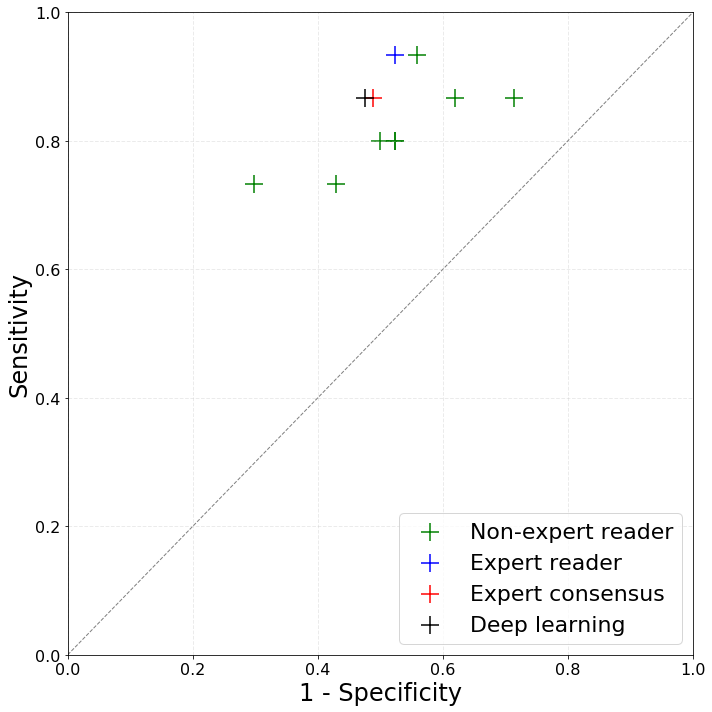

In [14]:
plt.figure(figsize=(10, 10))
marker_size = 324
maker_style = '+'
colors = ['olive', 'darkseagreen', 'teal', 'orange', 'mediumslateblue', 'orchid', 'palegoldenrod', 'chocolate', 'deepskyblue']
for i in range(8):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    label = 'Non-expert reader'
    color = 'green'
    plt.scatter(fpr_fna[i], tpr_fna[i], s=marker_size, color=color, marker=maker_style, label=(label if user_id in [723] else None))
plt.scatter(fpr_tirads_fna[1], tpr_tirads_fna[1], s=marker_size, color='blue', marker=maker_style, label='Expert reader')
plt.scatter(fpr_fna[8], tpr_fna[8], s=marker_size, color='red', marker=maker_style, label='Expert consensus')
plt.scatter(fpr_dl_fna[1], tpr_dl_fna[1], s=marker_size, color='black', marker=maker_style, label='Deep learning')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('', fontsize='xx-large')
plt.xlabel('1 - Specificity', fontsize=24)
plt.ylabel('Sensitivity', fontsize=24)
plt.legend(loc='lower right', fontsize=22)
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)
plt.tight_layout()

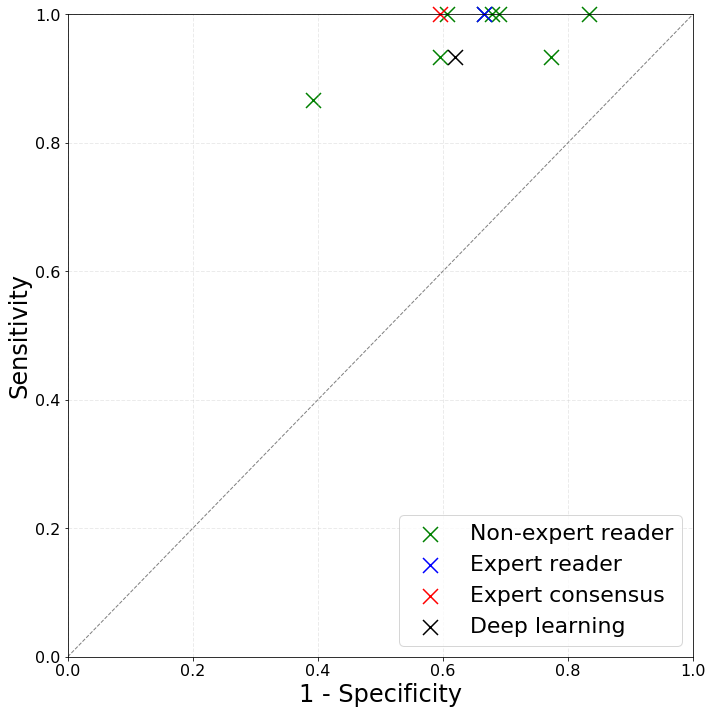

In [15]:
plt.figure(figsize=(10, 10))
marker_size = 225
maker_style = 'x'
colors = ['olive', 'darkseagreen', 'teal', 'orange', 'mediumslateblue', 'orchid', 'palegoldenrod', 'chocolate', 'deepskyblue']
for i in range(8):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    label = 'Non-expert reader'
    color = 'green'
    fpr_fna[i] = fpr_fna[i]
    tpr_fna[i] = tpr_fna[i]
    plt.scatter(fpr_follow[i], tpr_follow[i], s=marker_size, color=color, marker=maker_style, label=(label if user_id in [723] else None), clip_on=False)
plt.scatter(fpr_tirads_follow[1], tpr_tirads_follow[1], s=marker_size, color='blue', marker=maker_style, label='Expert reader', clip_on=False)
plt.scatter(fpr_follow[8], tpr_follow[8], s=marker_size, color='red', marker=maker_style, label='Expert consensus', clip_on=False)
plt.scatter(fpr_dl_follow[1], tpr_dl_follow[1], s=marker_size, color='black', marker=maker_style, label='Deep learning', clip_on=False)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('', fontsize='xx-large')
plt.xlabel('1 - Specificity', fontsize=24)
plt.ylabel('Sensitivity', fontsize=24)
plt.legend(loc='lower right', fontsize=22)
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)
plt.tight_layout()